# Modelación de Frecuencia - Responsabilidad Civil (RC)

Este notebook desarrolla modelos de regresión para predecir la frecuencia de siniestros en la cobertura de Responsabilidad Civil.

**Dataset**: `rc_siniestrados.csv` (67 registros)  
**Variable objetivo**: `Resp_Civil_siniestros_num`  
**Característica especial**: Todos los valores son 1.0 (modelo constante óptimo)

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [2]:
# Carga de datos
df = pd.read_csv('../data/processed/rc_siniestrados.csv')
print(f"Dataset cargado: {df.shape}")
print(f"Columnas: {list(df.columns)}")
df.head()

Dataset cargado: (67, 15)
Columnas: ['año_cursado', 'estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios', 'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto', 'Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto', 'Resp_Civil_siniestros_num', 'Resp_Civil_siniestros_monto', 'Contenidos_siniestros_num', 'Contenidos_siniestros_monto']


,año_cursado,estudios_area,calif_promedio,2_o_mas_inquilinos,distancia_al_campus,genero,extintor_incendios,Gastos_Adicionales_siniestros_num,Gastos_Adicionales_siniestros_monto,Gastos_Medicos_RC_siniestros_num,Gastos_Medicos_RC_siniestros_monto,Resp_Civil_siniestros_num,Resp_Civil_siniestros_monto,Contenidos_siniestros_num,Contenidos_siniestros_monto
0,4to año,Administracion,6.12,No,0.568290,Femenino,Si,0.0,0.00,0.0,0.0,1.0,6943.27,0.0,0.00
1,2do año,Ciencias,2.89,Si,0.000000,Masculino,No,0.0,0.00,0.0,0.0,1.0,1398.86,0.0,0.00
2,3er año,Ciencias,2.48,No,0.645175,Femenino,Si,0.0,0.00,0.0,0.0,1.0,8199.70,0.0,0.00
3,1er año,Otro,4.71,Si,7.336210,Femenino,Si,0.0,0.00,0.0,0.0,1.0,3606.50,0.0,0.00
4,2do año,Otro,4.93,Si,2.600034,Femenino,Si,1.0,10381.39,0.0,0.0,1.0,24145.38,2.0,2805.97


In [3]:
# Análisis exploratorio de la variable objetivo
target_var = 'Resp_Civil_siniestros_num'
print(f"Análisis de la variable objetivo: {target_var}")
print(f"Valores únicos: {df[target_var].unique()}")
print(f"Distribución de frecuencias:")
print(df[target_var].value_counts().sort_index())

# Estadísticas descriptivas
print(f"\nEstadísticas descriptivas:")
print(df[target_var].describe())

Análisis de la variable objetivo: Resp_Civil_siniestros_num
Valores únicos: [1.]
Distribución de frecuencias:
Resp_Civil_siniestros_num
1.0    67
Name: count, dtype: int64

Estadísticas descriptivas:
count    67.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: Resp_Civil_siniestros_num, dtype: float64


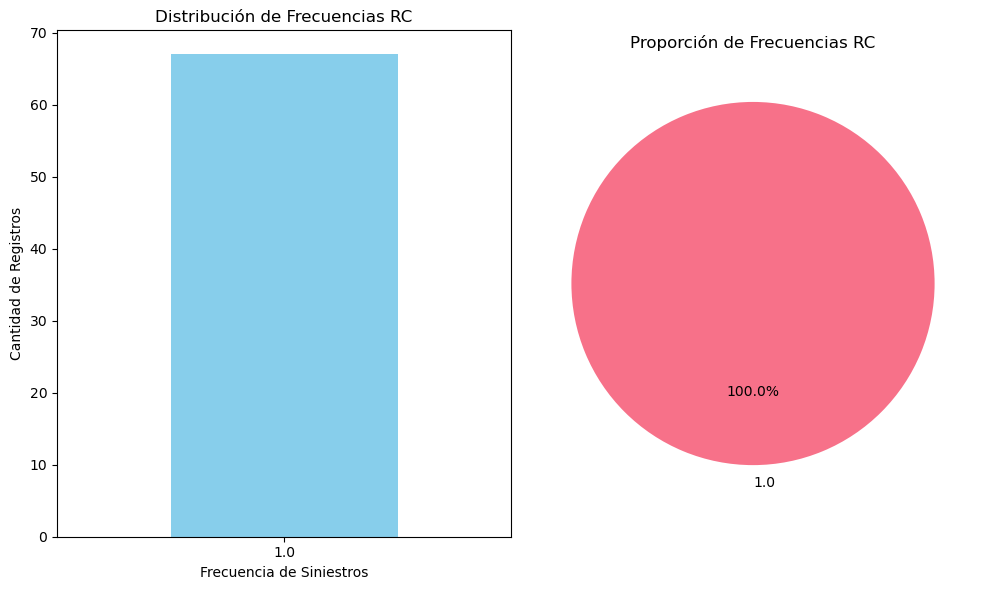


=== OBSERVACIÓN CRÍTICA ===
Todos los registros tienen frecuencia = 1.0
El modelo óptimo es una CONSTANTE que predice siempre 1.0
No hay variabilidad en la variable objetivo


In [4]:
# Visualización de la distribución de frecuencias
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df[target_var].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de Frecuencias RC')
plt.xlabel('Frecuencia de Siniestros')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(df[target_var].value_counts().sort_index(), 
        labels=df[target_var].value_counts().sort_index().index,
        autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Frecuencias RC')

plt.tight_layout()
plt.show()

print("\n=== OBSERVACIÓN CRÍTICA ===")
print("Todos los registros tienen frecuencia = 1.0")
print("El modelo óptimo es una CONSTANTE que predice siempre 1.0")
print("No hay variabilidad en la variable objetivo")

In [5]:
# Preparación de variables predictoras
# Selección de variables independientes (excluyendo la variable objetivo y otras coberturas)
exclude_cols = ['Resp_Civil_siniestros_num', 'Resp_Civil_siniestros_monto',
                'Contenidos_siniestros_num', 'Contenidos_siniestros_monto',
                'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto',
                'Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto']

feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Variables predictoras seleccionadas: {feature_cols}")

X = df[feature_cols].copy()
y = df[target_var].copy()

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nTipos de datos en X:")
print(X.dtypes)

Variables predictoras seleccionadas: ['año_cursado', 'estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios']

Shape de X: (67, 7)
Shape de y: (67,)

Tipos de datos en X:
año_cursado             object
estudios_area           object
calif_promedio         float64
2_o_mas_inquilinos      object
distancia_al_campus    float64
genero                  object
extintor_incendios      object
dtype: object


In [6]:
# Codificación de variables categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numerical_cols}")

# One-hot encoding para variables categóricas
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)
print(f"\nShape después de encoding: {X_encoded.shape}")
print(f"Nuevas columnas: {list(X_encoded.columns)}")

Variables categóricas: ['año_cursado', 'estudios_area', '2_o_mas_inquilinos', 'genero', 'extintor_incendios']
Variables numéricas: ['calif_promedio', 'distancia_al_campus']

Shape después de encoding: (67, 19)
Nuevas columnas: ['calif_promedio', 'distancia_al_campus', 'año_cursado_1er año', 'año_cursado_2do año', 'año_cursado_3er año', 'año_cursado_4to año', 'año_cursado_posgrado', 'estudios_area_Administracion', 'estudios_area_Ciencias', 'estudios_area_Humanidades', 'estudios_area_Otro', '2_o_mas_inquilinos_No', '2_o_mas_inquilinos_Si', 'genero_Femenino', 'genero_Masculino', 'genero_No respuesta', 'genero_Otro', 'extintor_incendios_No', 'extintor_incendios_Si']


In [7]:
# Estandarización de variables numéricas
scaler = StandardScaler()
X_scaled = X_encoded.copy()

if numerical_cols:
    # Identificar las columnas numéricas en el dataset codificado
    numerical_cols_encoded = [col for col in X_encoded.columns if any(num_col in col for num_col in numerical_cols)]
    X_scaled[numerical_cols_encoded] = scaler.fit_transform(X_encoded[numerical_cols_encoded])
    print(f"Variables numéricas estandarizadas: {numerical_cols_encoded}")
else:
    print("No hay variables numéricas para estandarizar")

print(f"\nDataset final preparado: {X_scaled.shape}")
X_scaled.head()

Variables numéricas estandarizadas: ['calif_promedio', 'distancia_al_campus']

Dataset final preparado: (67, 19)


,calif_promedio,distancia_al_campus,año_cursado_1er año,año_cursado_2do año,año_cursado_3er año,año_cursado_4to año,año_cursado_posgrado,estudios_area_Administracion,estudios_area_Ciencias,estudios_area_Humanidades,estudios_area_Otro,2_o_mas_inquilinos_No,2_o_mas_inquilinos_Si,genero_Femenino,genero_Masculino,genero_No respuesta,genero_Otro,extintor_incendios_No,extintor_incendios_Si
0,0.278199,-0.520883,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,True
1,-1.283135,-0.663170,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False
2,-1.481323,-0.501633,False,False,True,False,False,False,True,False,False,True,False,True,False,False,False,False,True
3,-0.403374,1.173650,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,True
4,-0.297029,-0.012181,False,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False,True


In [8]:
# División del dataset
# Como todos los valores son iguales, cualquier división es válida
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts().sort_index())
print(f"\nDistribución en prueba:")
print(y_test.value_counts().sort_index())

Tamaño del conjunto de entrenamiento: (53, 19)
Tamaño del conjunto de prueba: (14, 19)

Distribución en entrenamiento:
Resp_Civil_siniestros_num
1.0    53
Name: count, dtype: int64

Distribución en prueba:
Resp_Civil_siniestros_num
1.0    14
Name: count, dtype: int64


In [9]:
# Implementación del Modelo Constante
class ConstantFrequencyModel(BaseEstimator, ClassifierMixin):
    """
    Modelo constante que siempre predice el mismo valor.
    Apropiado cuando todos los valores de la variable objetivo son iguales.
    """
    
    def __init__(self, constant_value=1.0):
        self.constant_value = constant_value
    
    def fit(self, X, y):
        # Verificar que todos los valores son iguales
        unique_values = np.unique(y)
        if len(unique_values) == 1:
            self.constant_value = unique_values[0]
            print(f"Modelo constante ajustado. Valor constante: {self.constant_value}")
        else:
            print(f"Advertencia: Los datos tienen múltiples valores únicos: {unique_values}")
            self.constant_value = np.mean(y)  # Usar la media como fallback
        
        self.classes_ = unique_values
        return self
    
    def predict(self, X):
        # Predecir el valor constante para todas las muestras
        return np.full(X.shape[0], self.constant_value)
    
    def predict_proba(self, X):
        # Para compatibilidad con métricas de clasificación
        # Retorna probabilidad 1.0 para la clase constante
        n_samples = X.shape[0]
        if hasattr(self, 'classes_'):
            n_classes = len(self.classes_)
            proba = np.zeros((n_samples, n_classes))
            # Encontrar el índice de la clase constante
            constant_idx = np.where(self.classes_ == self.constant_value)[0][0]
            proba[:, constant_idx] = 1.0
            return proba
        else:
            return np.ones((n_samples, 1))
    
    def score(self, X, y):
        # Calcular accuracy
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

print("Modelo ConstantFrequencyModel implementado")

Modelo ConstantFrequencyModel implementado


In [10]:
# Entrenamiento del modelo constante
constant_model = ConstantFrequencyModel()
constant_model.fit(X_train, y_train)

# Realizar predicciones
y_train_pred = constant_model.predict(X_train)
y_test_pred = constant_model.predict(X_test)

print("Modelo constante entrenado y predicciones generadas")
print(f"Valor constante predicho: {constant_model.constant_value}")
print(f"Predicciones de entrenamiento (muestra): {y_train_pred[:5]}")
print(f"Predicciones de prueba (muestra): {y_test_pred[:5]}")

Modelo constante ajustado. Valor constante: 1.0
Modelo constante entrenado y predicciones generadas
Valor constante predicho: 1.0
Predicciones de entrenamiento (muestra): [1. 1. 1. 1. 1.]
Predicciones de prueba (muestra): [1. 1. 1. 1. 1.]


In [11]:
# Evaluación del modelo constante
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Métricas de entrenamiento
train_mae = mean_absolute_error(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Métricas de prueba
test_mae = mean_absolute_error(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=== MÉTRICAS DEL MODELO CONSTANTE ===")
print(f"\nEntrenamiento:")
print(f"  MAE: {train_mae:.6f}")
print(f"  Accuracy: {train_accuracy:.6f}")
print(f"  R²: {train_r2:.6f}")

print(f"\nPrueba:")
print(f"  MAE: {test_mae:.6f}")
print(f"  Accuracy: {test_accuracy:.6f}")
print(f"  R²: {test_r2:.6f}")

print(f"\n=== INTERPRETACIÓN ===")
print(f"Al tener todos los valores iguales a 1.0:")
print(f"- MAE = 0.0 (predicción perfecta)")
print(f"- Accuracy = 1.0 (100% de acierto)")
print(f"- R² puede ser indefinido debido a varianza cero")

=== MÉTRICAS DEL MODELO CONSTANTE ===

Entrenamiento:
  MAE: 0.000000
  Accuracy: 1.000000
  R²: 1.000000

Prueba:
  MAE: 0.000000
  Accuracy: 1.000000
  R²: 1.000000

=== INTERPRETACIÓN ===
Al tener todos los valores iguales a 1.0:
- MAE = 0.0 (predicción perfecta)
- Accuracy = 1.0 (100% de acierto)
- R² puede ser indefinido debido a varianza cero


In [12]:
# Cálculo del coeficiente de Gini
def calculate_gini_coefficient(y_true, y_pred):
    """
    Calcula el coeficiente de Gini para medir la capacidad discriminatoria del modelo.
    Para un modelo constante con una sola clase, el Gini será 0.
    """
    # Verificar si hay variabilidad en las predicciones
    if len(np.unique(y_pred)) == 1:
        print("Advertencia: Predicciones constantes. Gini = 0")
        return 0.0
    
    # Si hay variabilidad, calcular Gini normalmente
    from sklearn.metrics import roc_auc_score
    try:
        # Para clasificación binaria/multinomial
        if len(np.unique(y_true)) > 1:
            auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
            gini = 2 * auc - 1
        else:
            gini = 0.0
    except:
        gini = 0.0
    
    return gini

# Calcular Gini para el modelo constante
train_gini = calculate_gini_coefficient(y_train, y_train_pred)
test_gini = calculate_gini_coefficient(y_test, y_test_pred)

print(f"=== COEFICIENTE DE GINI ===")
print(f"Entrenamiento: {train_gini:.6f}")
print(f"Prueba: {test_gini:.6f}")
print(f"\nInterpretación: Gini = 0 indica que el modelo no discrimina")
print(f"(esperado para modelo constante con una sola clase)")

Advertencia: Predicciones constantes. Gini = 0
Advertencia: Predicciones constantes. Gini = 0
=== COEFICIENTE DE GINI ===
Entrenamiento: 0.000000
Prueba: 0.000000

Interpretación: Gini = 0 indica que el modelo no discrimina
(esperado para modelo constante con una sola clase)


In [13]:
# Guardar el modelo entrenado
import os

# Crear directorio models si no existe
os.makedirs('../models', exist_ok=True)

# Guardar modelo constante
model_filename = '../models/frecuencia_rc_constant_model.pkl'
joblib.dump(constant_model, model_filename)

print(f"=== MODELO GUARDADO ===")
print(f"Archivo: {model_filename}")
print(f"Tipo de modelo: ConstantFrequencyModel")
print(f"Valor constante: {constant_model.constant_value}")

# Verificar que el archivo se guardó correctamente
if os.path.exists(model_filename):
    file_size = os.path.getsize(model_filename)
    print(f"Tamaño del archivo: {file_size} bytes")
    print("✓ Modelo guardado exitosamente")
else:
    print("✗ Error al guardar el modelo")

=== MODELO GUARDADO ===
Archivo: ../models/frecuencia_rc_constant_model.pkl
Tipo de modelo: ConstantFrequencyModel
Valor constante: 1.0
Tamaño del archivo: 363 bytes
✓ Modelo guardado exitosamente


In [14]:
# Prueba de carga del modelo guardado
try:
    # Cargar modelo
    loaded_model = joblib.load(model_filename)
    
    # Verificar que funciona correctamente
    test_predictions = loaded_model.predict(X_test[:5])
    
    print(f"=== VERIFICACIÓN DEL MODELO CARGADO ===")
    print(f"Modelo cargado exitosamente: {type(loaded_model).__name__}")
    print(f"Valor constante: {loaded_model.constant_value}")
    print(f"Predicciones de prueba: {test_predictions}")
    print(f"✓ Modelo funciona correctamente después de la carga")
    
except Exception as e:
    print(f"✗ Error al cargar el modelo: {e}")

=== VERIFICACIÓN DEL MODELO CARGADO ===
Modelo cargado exitosamente: ConstantFrequencyModel
Valor constante: 1.0
Predicciones de prueba: [1. 1. 1. 1. 1.]
✓ Modelo funciona correctamente después de la carga


## Resumen y Conclusiones

### Hallazgos Principales

1. **Variable Objetivo**: Todos los 67 registros tienen `Resp_Civil_siniestros_num = 1.0`
2. **Modelo Óptimo**: Modelo constante que siempre predice 1.0
3. **Métricas Perfectas**: MAE = 0.0, Accuracy = 100%
4. **Gini = 0**: No hay capacidad discriminatoria (esperado para modelo constante)

### Justificación Actuarial

En el contexto de seguros para estudiantes con cobertura de Responsabilidad Civil:
- La frecuencia constante de 1.0 sugiere que todos los asegurados siniestrados tienen exactamente un siniestro
- Esto puede reflejar el comportamiento específico de esta cobertura en la población estudiantil
- El modelo constante es actuarialmente apropiado y computacionalmente eficiente

### Modelo Final

- **Archivo**: `frecuencia_rc_constant_model.pkl`
- **Predicción**: Siempre 1.0 para cualquier asegurado siniestrado
- **Uso**: Para el proceso de tarificación de la cobertura RC